# Adam Thomson - PHY573 - Week 4

## Bernstein-Vazirani Algorithm

The goal of the Bernstein-Vazirani Algorithm is to determine the unknown bit-string associated with a black-box function. This function will return the bit-wise product of an input string and the secret string that needs to be solved for. The classical solution to this problem requires querying the function n times, where n is the input length.

The quantum solution to this problem requires only a single call of the black-box function! It accomplishes this by first passing the initial input qubits |00..0> through Hadamard gates to create a superposition state |++..+> that gets fed into the black-box function. This will "phase flip" the bits associated with the secret string to |->, this means after another Hadamard transformation is applied to all input qubits, measurement will then reveal the unknown string.

Let's follow the qiskit example here to see how https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/bernstein-vazirani.ipynb

### Example algorithm implementation

In [26]:
# Import libraries
import numpy as np
from IPython.display import Math, HTML
from qiskit import QuantumCircuit as QCir, transpile
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator

sampler = AerSimulator()

In [22]:
display(Math(r'''
\text{Let's examine the specific example of a 2-bit secret string. We'll start with s=11 but modify to find an unknown value further down}
'''))

display(Math(r'''
\text{Start by declaring the initial state}
\\\\ \ket{\psi_0} = \ket{00}
'''))

display(Math(r'''
\text{Next, apply a Hadamard gate to both qubits}
\\\\ \ket{\psi_1} = H^{\otimes2} \ket{\psi_0} = \frac1{\sqrt2}(\ket0 + \ket1) \otimes \frac1{\sqrt2}(\ket0 + \ket1)
\\\\ \ket{\psi_1} = \frac12 ( \ket{00} + \ket{01} + \ket{10} + \ket{11})
'''))

display(Math(r'''
\text{Define the oracle function}
\\\\ f_s := f_s\ket x = (-1)^{x \cdot s}\ket x = (-1)^{x \cdot 11}\ket x
'''))

display(Math(r'''
\text{And then apply it to our state}
\\\\ \ket{\psi_2} = f_s \ket{\psi_1} = \frac12 [
    f_s \ket{00} + f_s \ket{01} + f_s \ket{10} + f_s \ket{11}
]
\\\\ \ket{\psi_2} = \frac12 [
    (-1)^{00 \cdot 11} \ket{00} + (-1)^{01 \cdot 11} \ket{01} + (-1)^{10 \cdot 11} \ket{10} + (-1)^{11 \cdot 11} \ket{11} + 
]
\\\\ \ket{\psi_2} = \frac12 ( \ket{00} + (-1)\ket{01} + (-1)\ket{10} + (-1)^2\ket{11} )
\\\\ \ket{\psi_2} = \frac12 ( \ket{00} - \ket{01} - \ket{10} + \ket{11} )
'''))

display(Math(r'''
\text{Finally, apply a Hadamard gate to both qubits again to get the secret string.}
\\\\ \ket{\psi_3} = H^{\otimes2}\ket{\psi_2} = H^{\otimes2}(\frac12 ( \ket{00} - \ket{01} - \ket{10} + \ket{11} ))
\\\\ \ket{\psi_3} = H^{\otimes2}((\ket0 - \ket1) \otimes (\ket0 - \ket1))
\\\\ \ket{\psi_3} = H(\ket0 - \ket1) \otimes H(\ket0 - \ket1) = \ket1 \otimes \ket1
\\\\ \ket{\psi_3} = \ket{11}
'''))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Qiskit implementation

Let's now construct a quantum circuit with qiskit to find a 3-bit string, s=101

In [50]:
# Setup high-level variables
n = 3
s = '101'

def validate_input():
    assert len(s) == n
    for i in s:
        assert i in ['0', '1']

def set_random_secret():
    b = np.random.randint(2**n)
    return format(b, f'0{n}b')

## Uncomment next line to use a truly secret oracle function
# s = set_random_secret()

validate_input()

In [51]:
# Provide a way to peek into the black box to confirm results
reveal_secret = f'''
<details>
    <summary>Click here to reveal the secret!</summary>
    s={s}
</details>
'''
HTML(reveal_secret)

In [53]:
# Initialize the quantum circuit
# uses n qubits plus 1 auxiliary qubit, and n cbits for measurement
bv_circuit = QCir(n+1, n)

# flip auxiliary qubit to |-> state
bv_circuit.x(n)
bv_circuit.h(n)

# apply H gates
for i in range(n):
    bv_circuit.h(i)

bv_circuit.barrier()

# apply oracle
_s = s[::1] # reverse s to fit qiskit ordering
for q in range(n):
    if _s[q] == '1':
        bv_circuit.cx(q,n)  # apply CNOT on auxiliary bit with input bit as control
    else:
        pass  # Do nothing, I-gate is deprecated

bv_circuit.barrier()

# apply H gates again
for i in range(n):
    bv_circuit.h(i)

# measure to classical register
for i in range(n):
    bv_circuit.measure(i,i)

bv_circuit.draw()

┌───┐      ░            ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░───■────────░─┤ H ├┤M├──────
     ├───┤      ░   │        ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───┼────────░─┤ H ├─╫─┤M├───
     ├───┤      ░   │        ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼────■───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘ ░       ║  ║  ║ 
c: 3/════════════════════════════════╩══╩══╩═
                                     0  1  2

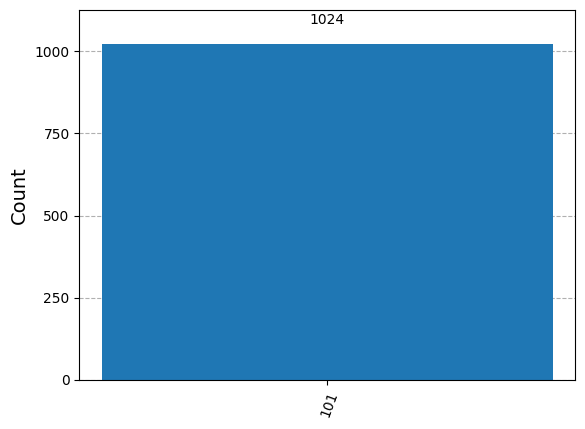

In [55]:
# run on local simulation
results = sampler.run(bv_circuit).result()
plot_histogram(results.get_counts())

100% of measurements match our expected `s`!

### Experimenting on real devices

In [56]:
# Additional imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

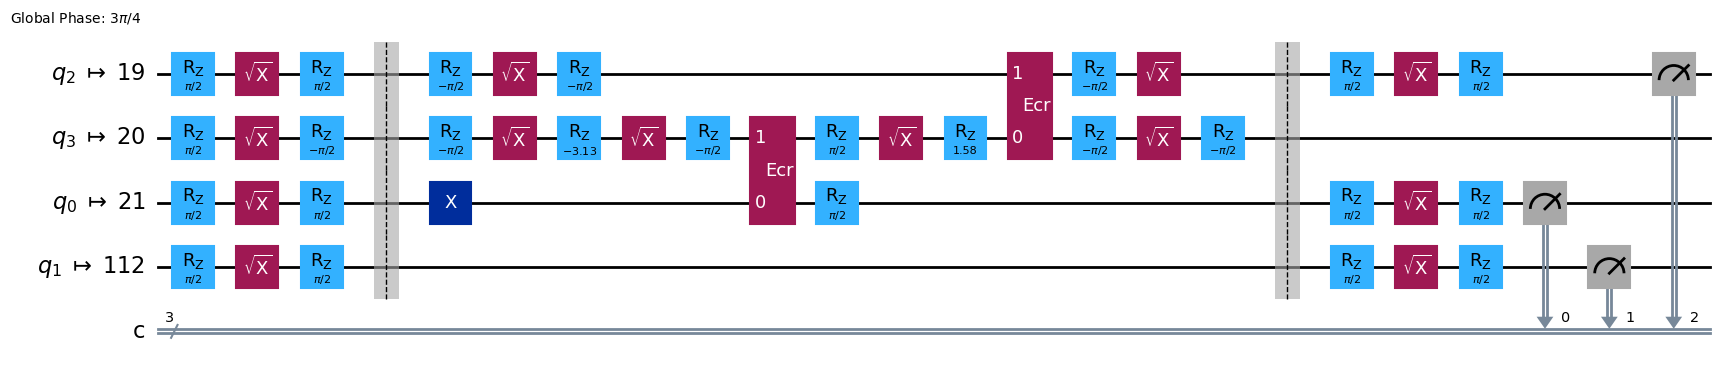

In [57]:
# Transpile the circuit for operating on real quantum hardward
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(bv_circuit)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [58]:
# Run the circuit and wait for the results
sampler2 = SamplerV2(mode=backend)
sampler2.options.default_shots = 1_000
result = sampler2.run([circuit_isa]).result()[0]

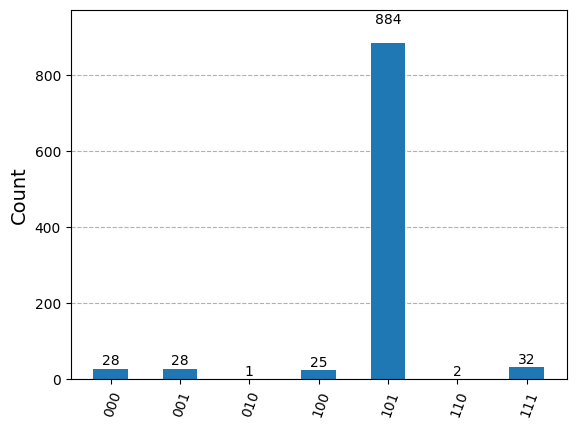

In [59]:
# Plot the results
test_counts = result.data.c.get_counts()
plot_histogram(test_counts)

Most results matched our expected s, but there were other values measured due to errors on the quantum device.